###  Transfer Learning with TensorFlow Part 1: Feature Extraction

We've built a bunch of convolutional neural networks from scratch and they all seem to be learning, however, there is still plenty of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called **transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

* Can leverage an existing neural network architecture proven to work on problems similar to our own.
* Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.
What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as **ImageNet** (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

### Using GPU


To begin, let's check to see if we're using a GPU. Using a GPU will make sure our model trains faster than using just a CPU.

In [11]:
# Are we using a GPU?
!nvidia-smi

Sun Jan 23 11:26:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data

However, what if you didn't have more data? What if instead of 750 images per class, you had 75 images per class?

Collecting 675 more images of a certain class could take a long time.

So this is where another major benefit of transfer learning comes in.

Transfer learning often allows you to get great results with less data.

### Downloading and becoming one with the data

In [12]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-01-23 11:31:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   312MB/s    in 0.5s    

2022-01-23 11:31:28 (312 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [13]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

### Creating data loaders (preparing the data)

In [14]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print("Testing images:")
test_data_10_percent = train_datagen.flow_from_directory(test_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [38]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


### Setting up callbacks (things to run whilst our model trains)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is callbacks.

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [15]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

* dir_name is the overall logs directory
* experiment_name is the particular experiment
* current_timestamp is the time the experiment started based on Python's datetime.datetime().now()

### Creating models using TensorFlow Hub

In fact, we're going to use two models from TensorFlow Hub:

* ResNetV2 - a state of the art computer vision model architecture from 2016.
* EfficientNet - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on ImageNet (ILSVRC-2012-CLS), the gold standard of computer vision benchmarks.

You might be wondering, how do you find these models on TensorFlow Hub?

Here are the steps I took:

* Go to tfhub.dev.
* Choose your problem domain, e.g. "Image" (we're using food images).
* Select your TF version, which in our case is TF2.
* Remove all "Problem domanin" filters except for the problem you're working on.
* Note: "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
The models listed are all models which could potentially be used for your problem.

* "As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.

For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.
* Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.
* Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [17]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [18]:
def create_model(model_url, num_classes=10):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

Great! Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.

In [19]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [21]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220123-120447
Epoch 1/5
24/24 [==============================] - 31s 779ms/step - loss: 1.9565 - accuracy: 0.3440 - val_loss: 1.2244 - val_accuracy: 0.6172
Epoch 2/5
24/24 [==============================] - 16s 704ms/step - loss: 0.9206 - accuracy: 0.7213 - val_loss: 0.8709 - val_accuracy: 0.7272
Epoch 3/5
24/24 [==============================] - 16s 704ms/step - loss: 0.6442 - accuracy: 0.8173 - val_loss: 0.7607 - val_accuracy: 0.7520
Epoch 4/5
24/24 [==============================] - 16s 706ms/step - loss: 0.4981 - accuracy: 0.8707 - val_loss: 0.7215 - val_accuracy: 0.7628
Epoch 5/5
24/24 [==============================] - 16s 707ms/step - loss: 0.4054 - accuracy: 0.8973 - val_loss: 0.6802 - val_accuracy: 0.7780


It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our plot_loss_curves function.

In [23]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

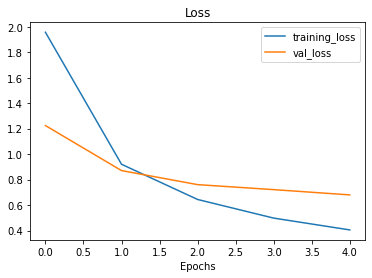

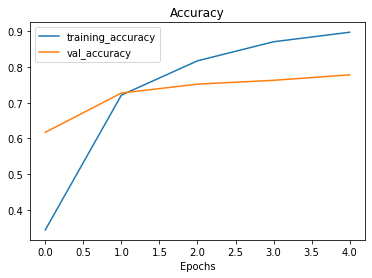

In [24]:
plot_loss_curves(resnet_history)

And what about a summary of our model?

In [25]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set trainable=False, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

In [31]:
# Create a model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=7,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensoflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensoflow_hub/efficientnetB0/20220123-122421
Epoch 1/7
24/24 [==============================] - 25s 720ms/step - loss: 1.8110 - accuracy: 0.4347 - val_loss: 1.2659 - val_accuracy: 0.7552
Epoch 2/7
24/24 [==============================] - 16s 674ms/step - loss: 1.0329 - accuracy: 0.7800 - val_loss: 0.8489 - val_accuracy: 0.8296
Epoch 3/7
24/24 [==============================] - 16s 670ms/step - loss: 0.7386 - accuracy: 0.8280 - val_loss: 0.6872 - val_accuracy: 0.8504
Epoch 4/7
24/24 [==============================] - 16s 668ms/step - loss: 0.5980 - accuracy: 0.8613 - val_loss: 0.6019 - val_accuracy: 0.8596
Epoch 5/7
24/24 [==============================] - 16s 668ms/step - loss: 0.5075 - accuracy: 0.9000 - val_loss: 0.5518 - val_accuracy: 0.8644
Epoch 6/7
24/24 [==============================] - 16s 668ms/step - loss: 0.4386 - accuracy: 0.9080 - val_loss: 0.5167 - val_accuracy: 0.8720
Epoch 7/7
24/24 [==============================] - 16s 669ms/step - lo

The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...again with only 10% of the training data.

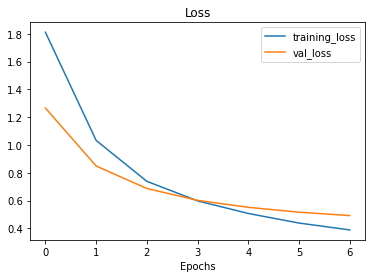

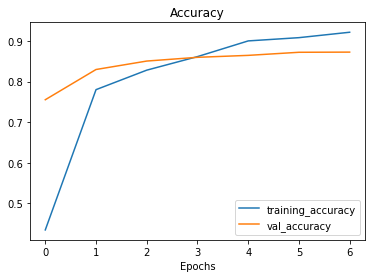

In [32]:
# Let's check out the loss curves.
plot_loss_curves(efficientnet_history)

From the look of the EfficientNetB0 model's loss curves, it looks like if we kept training our model for longer, it might improve even further. Perhaps that's something you might want to try?

In [33]:
# Let's check out the model summary
efficientnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


It seems despite having over four times less parameters (4,049,564 vs. 23,564,800) than the ResNet50V2 extraction layer, the EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the "efficient" name came from.

In [34]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # Our model is trained on images with 3 colour channels and sometimes images 4 colour channels
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (one-hot encode)
  img = img/255.
  return img

In [45]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [40]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

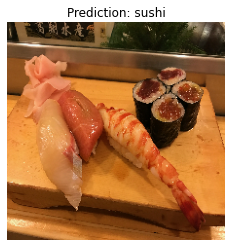

In [46]:
# Test our model on a custom image
pred_and_plot(efficientnet_model, "03-sushi.jpeg", class_names)

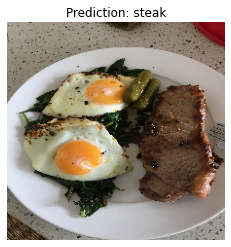

In [48]:
# Test our model on a custom image
pred_and_plot(efficientnet_model, "03-steak.jpeg", class_names)

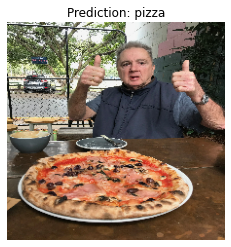

In [49]:
# Test our model on a custom image
pred_and_plot(efficientnet_model, "03-pizza-dad.jpeg", class_names)

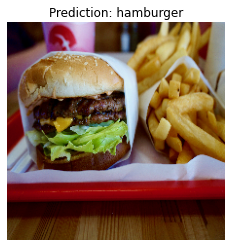

In [50]:
# Test our model on a custom image
pred_and_plot(efficientnet_model, "03-hamburger.jpeg", class_names)

### Comparing models using TensorBoard

Alright, even though we've already compared the performance of our two models by looking at the accuracy scores. But what if you had more than two models?

That's where an experiment tracking tool like TensorBoard (preinstalled in Google Colab) comes in.

The good thing is, since we set up a TensorBoard callback, all of our model's training logs have been saved automatically. To visualize them, we can upload the results to TensorBoard.dev.

Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompanying Colab notebook.

### Uploading experiments to TensorBoard

To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \ 
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \ 
  --one_shot
Where:

* --logdir is the target upload directory
* --name is the name of the experiment
* --description is a brief description of the experiment
* --one_shot exits the TensorBoard uploader once uploading is finished
Running the tensorboard dev upload command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded.

In [51]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensoflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensoflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=UEZ9b2X2Ou3J7YYevCcl1u2lOVbrz0&prompt=consent&access_type=offl

### Listing experiments you've saved to TensorBoard

In [52]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/L0YTdPo1QnyuYBBLYFW48Q/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   L0YTdPo1QnyuYBBLYFW48Q
	Created              2022-01-23 12:51:32 (10 minutes ago)
	Updated              2022-01-23 12:51:35 (10 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              102
	Tensor bytes         0
	Binary object bytes  12236402
Total: 1 experiment(s)


### Deleting experiments from TensorBoard

In [53]:
# Delete an experiment
!tensorboard dev delete --experiment_id L0YTdPo1QnyuYBBLYFW48Q

Deleted experiment L0YTdPo1QnyuYBBLYFW48Q.


In [54]:
# Check to see if experiments still exist
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
